In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image
import tensorflow as tf
import logging
import warnings
from tqdm.notebook import tqdm
import random

In [2]:
IMAGE_FOLDERS = [
    os.path.join(os.pardir, "data", "Tadaki+20_spiral", "Tadaki+20_Z"),
    os.path.join(os.pardir, "data", "Tadaki+20_spiral", "Tadaki+20_S"),
]
MASK_FOLDER = os.path.join(
    os.pardir, "data", "Tadaki+20_spiral", "Tadaki+20_spiral_predictions"
)
MODEL_PATH = os.path.join(os.pardir, "models", "tuned_model.keras")
CATALOG_PATH = os.path.join(
    os.pardir, "data", "Tadaki+20_spiral", "Tadaki+20_spiral.csv"
)
UPDATED_CATALOG_PATH = os.path.join(
    os.pardir, "data", "Tadaki+20_spiral", "Tadaki+20_spiral_updated.csv"
)

In [3]:
# Seaborn styling

sns.set_context("notebook")

# Set the font to be serif, rather than sans
sns.set(font="serif")
# Make the background white, and specify the
# specific font family
sns.set_style(
    "whitegrid",
    {"font.family": "serif", "font.serif": ["Times", "Palatino", "serif"]},
)

### Base Methods

Compute Metrics for single image/mask pairs

---

`spiral_area_ratio(mask)` - Calculates ratio of masked area over total image area"

`pixel_intensity_ratio(mask, image)` - Calculates ratio of masked pixel intensity over full pixel intensity

$$
\textbf{p}_{sp} =   \sum_{x=1, y=1}^{m, n} \frac{\textbf{p}_{x,y}  \cdot  \text{s}_{x,y}}{\textbf{p}_{x,y}}\\
$$

`flux_ratio(mask, image)` - Calculates flux intensity ratio of masked segment over whole image

$$
\textbf{f}_{sp} =   \sum_{x=1, y=1}^{m, n} \frac{(\textbf{p}_{x,y})^{2.2}  \cdot  \text{s}_{x,y}}{(\textbf{p}_{x,y})^{2.2}}\\
$$

Where:

$\textbf{p}_{sp}$ is Ratio of pixel intensity of spiral segment to total pixel intensity, and

$\textbf{f}_{sp}$ is Ratio of estimated flux of spiral segment to total estimated flux, and

$\text{s}_{x,y}$ (spiral mask) is defined as follows:

$$
\text{s}_{x,y} =
\begin{cases}
1,  & \text{if $x,y$ in spiral mask} \\
0, & \text{if $x,y$ not in spiral mask}
\end{cases}
$$

---


In [4]:
def spiral_area_ratio(mask):
    """Calculates ratio of masked area over full area"""

    return np.sum(mask) / len(mask.flatten())

In [5]:
def pixel_intensity_ratio(mask, image):
    """Calculates ratio of masked pixel intensity over full pixel intensity"""

    return np.sum(image * mask) / np.sum(image)

In [6]:
def flux_ratio(mask, image):
    """Calculates flux intensity ratio of masked segment over whole image"""
    image_flux = image**2.2

    return pixel_intensity_ratio(mask, image_flux)

### Helper Methods

---

`get_image(image_id)` - Returns image numpy array for a given image id

`get_image_and_mask(image_id)` - Returns image and mask numpy array for a given image id

`get_pixel_intensity_ratios()` - Gets pixel intensity ratios for all images in IMAGE_FOLDER

`get_flux_ratios()` - Gets pixel intensity ratios for all images in IMAGE_FOLDER

---


In [7]:
def get_image(image_id):
    """Returns image numpy array for a given image id"""

    for folder in IMAGE_FOLDERS:
        image_path = os.path.join(folder, image_id + ".jpg")
        if os.path.exists(image_path):
            image = np.array(Image.open(image_path))
            return image

    raise FileNotFoundError(f"Image {image_id} not found")

In [8]:
def get_image_and_mask(image_id):
    """Returns image and mask numpy array for a given image id"""

    mask_path = os.path.join(MASK_FOLDER, image_id + ".png")
    mask = np.array(Image.open(mask_path))

    for folder in IMAGE_FOLDERS:
        image_path = os.path.join(folder, image_id + ".jpg")
        if os.path.exists(image_path):
            image = np.array(Image.open(image_path))
            return image, mask

    raise FileNotFoundError(f"Image {image_id} not found")

In [9]:
def get_pixel_intensity_ratios(masks=None, images=None):
    """
    Gets pixel intensity ratios for all images

    Uses either images and masks as input or loads them from disk
    """
    pixel_intensity_ratios = {}

    if images is not None and masks is not None:
        for image_id, image in images.items():
            mask = masks[image_id]
            pixel_intensity_ratios[image_id] = pixel_intensity_ratio(
                mask, image
            )
    else:
        for image_id in os.listdir(MASK_FOLDER):
            image_id = image_id.split(".")[0]
            image, mask = get_image_and_mask(image_id)
            pixel_intensity_ratios[image_id] = pixel_intensity_ratio(
                mask, image
            )

    return pixel_intensity_ratios

In [10]:
def get_flux_ratios(masks=None, images=None):
    """
    Gets flux ratios for all images

    Uses either images and masks as input or loads them from disk
    """

    flux_ratios = {}
    if images is not None and masks is not None:
        for image_id, image in images.items():
            mask = masks[image_id]
            flux_ratios[image_id] = flux_ratio(mask, image)
    else:
        for image_id in os.listdir(MASK_FOLDER):
            image_id = image_id.split(".")[0]
            image, mask = get_image_and_mask(image_id)
            flux_ratios[image_id] = flux_ratio(mask, image)

    return flux_ratios

### Prediction

---

`def get_predictions(prediction_folder=None, threshold=None, num_predictions=1000, overwrite=False, verbose=False)`

\- Loads tensorflow model at MODEL_PATH and returns predictions for images in IMAGE_FOLDERS

> Define `prediction_folder` to save predictions as binary (0, 1) png files
>
> - NOTE: if unset, predictions will not be saved!

> Set `num_predictions` to None to exhaust all images in folder
>
> - Suggested to keep set for large datasets, as it will take a long time to run for all images
> - GPU Acceleration is also recommended for large datasets
> - [Tested on Ryzen 5 5600X has runtime of ~41s per 1000 images]

> If `overwrite` is `True`, will discard all predictions at prediction_folder and replace with new predictions

> If `verbose` is `True`, will print progress bar to track execution

---


In [11]:
def get_predictions(
    prediction_folder=None,
    threshold=None,
    num_predictions=1000,
    overwrite=False,
    verbose=True,
):
    """
    Loads tensorflow model at MODEL_PATH and returns predictions for images in IMAGE_FOLDERS

    define prediction_folder to save predictions as binary (0, 1) png files
        -> NOTE: if unset, predictions will not be saved!
    set num_predictions to None to exhaust all images in folder
        -> Suggested to keep set for large datasets, as it will take a long time to run for all images
        -> GPU  Acceleration is also recommended for large datasets
        -> [Tested on Ryzen 5 5600X has runtime of ~41s per 1000 images]
    """

    # GPU info
    physical_devices = tf.config.list_physical_devices("GPU")
    if len(physical_devices) > 0:
        logging.info("GPU Acceleration Enabled")
    else:
        logging.info("GPU Acceleration Disabled")
        logging.info(
            "Consider enabling GPU Acceleration for faster predictions"
        )

    # If num_predictions is not set, warn user
    if num_predictions is None:
        logging.warning(
            "Running without num_predictions=None may take a long time!"
        )
        logging.info(
            "Process is interruptible using the stop button (or Ctrl+C, if supported)"
        )

    # Fetch model
    model = tf.keras.models.load_model(MODEL_PATH)

    # Get list of image paths
    image_list = [os.listdir(folder) for folder in IMAGE_FOLDERS]
    image_list = [item for sublist in image_list for item in sublist]

    if num_predictions is not None:
        image_list = image_list[:num_predictions]
    image_list = tqdm(
        image_list, desc="Images Processed", position=0, disable=not (verbose)
    )

    skipped_count = 0
    file_log = tqdm(total=0, position=1, bar_format="{desc}")
    file_log.set_description_str(f"Current file: ")
    skipped_log = tqdm(total=0, position=2, bar_format="{desc}")
    skipped_log.set_description_str(f"Skipped 0 files")

    images = {}
    predictions = {}

    for i, image_id in enumerate(image_list):
        if num_predictions is not None and i >= num_predictions:
            break

        # Get image
        image_id = image_id.split(".")[0]
        file_log.set_description_str(f"Current file: {image_id}")
        image = get_image(image_id)
        images[image_id] = image
        image = np.expand_dims(image, axis=0)

        if (
            prediction_folder is not None
            and os.path.exists(prediction_folder)
            and os.path.exists(
                os.path.join(prediction_folder, image_id + ".png")
            )
            and not overwrite
        ):
            # If prediction already exists, read existing prediction
            predictions[image_id] = np.array(
                Image.open(os.path.join(prediction_folder, image_id + ".png"))
            )
            skipped_count += 1
            skipped_log.set_description_str(f"Skipped {skipped_count} files")
            continue
        else:
            # Predict using model
            predictions[image_id] = model.predict(image, verbose=0).reshape(
                (64, 64)
            )

        if threshold is not None:
            predictions[image_id] = (predictions[image_id] > threshold).astype(
                np.uint8
            )

        if prediction_folder is not None and os.path.exists(prediction_folder):
            prediction = predictions[image_id]
            prediction = prediction.reshape((64, 64))
            prediction = Image.fromarray(prediction)
            prediction.save(os.path.join(prediction_folder, image_id + ".png"))

    return images, predictions

### Display Methods

Displays plots and images

---

`print_image_mask_pred(image, mask, prediction, title, threshold=0.5)` - Displays image, mask and prediction side by side

`print_image_pred(image, prediction, title, threshold=0.5)` - Displays image and prediction side by side

`show_prediction_sample(n_sample=5, display_mask=True)` - Displays 5 images with their masks (if specified) and predictions

---


In [12]:
def print_image_mask_pred(image, mask, prediction, title, threshold=0.5):
    """Displays image, mask and prediction side by side"""

    fig, ax = plt.subplots(1, 3, figsize=(15, 15))
    ax[0].imshow(image)
    ax[0].set_title("Image")
    ax[1].imshow(mask)
    ax[1].set_title("Mask")
    ax[2].imshow(prediction > threshold)
    ax[2].set_title("Prediction")

    # Turn off all axes
    for a in ax:
        a.axis("off")

    plt.suptitle(title, y=0.67, fontsize=16)

    plt.show()

In [13]:
def print_image_pred(image, prediction, title="", threshold=0.5):
    """Displays image and prediction side by side"""

    fig, ax = plt.subplots(1, 2, figsize=(15, 15))
    ax[0].imshow(image)
    ax[0].set_title("Image")
    ax[1].imshow(prediction > threshold)
    ax[1].set_title("Prediction")

    # Turn off all axes
    for a in ax:
        a.axis("off")

    plt.suptitle(title, y=0.74, fontsize=16)

    plt.show()

In [14]:
def show_prediction_sample(images=None, preds=None, n_sample=5, threshold=0.5):
    """Displays randon sample of images and their predictions"""

    if images is None and preds is None:
        images, preds = get_predictions(MODEL_PATH, num_predictions=n_sample)

    for image_id in random.sample(list(preds), n_sample):
        print_image_pred(
            images[image_id], preds[image_id], image_id, threshold=threshold
        )

## Experimentation Section


In [15]:
# Make predictions for images in IMAGE_FOLDERS
images, preds = get_predictions(
    prediction_folder=MASK_FOLDER,
    threshold=0.5,
    num_predictions=None,
    verbose=True,
)

Images Processed:   0%|          | 0/76545 [00:00<?, ?it/s]

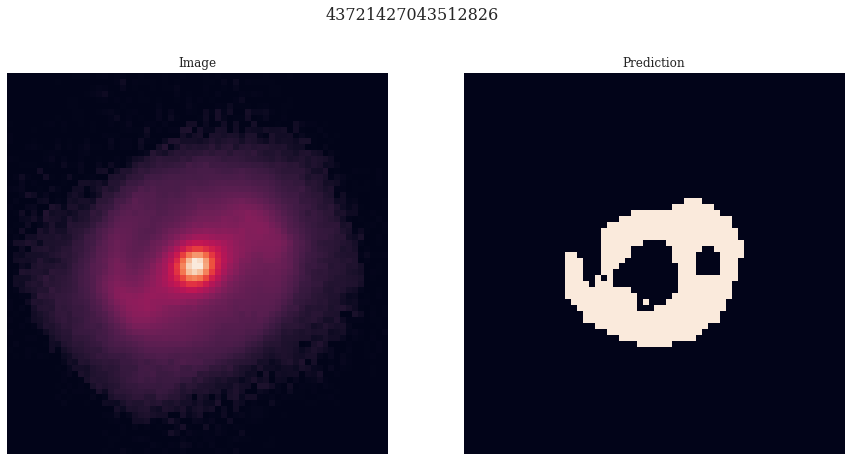

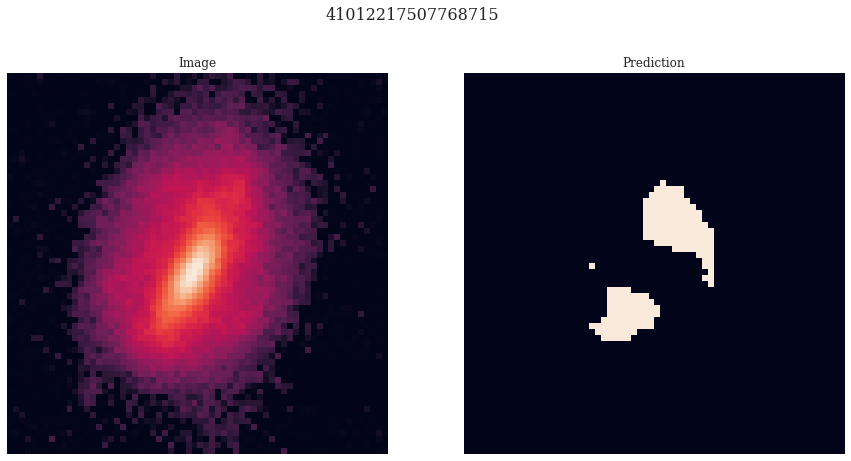

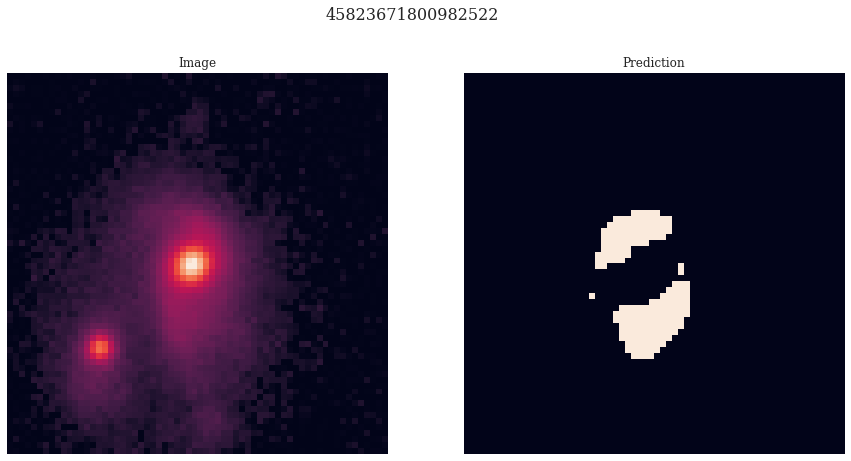

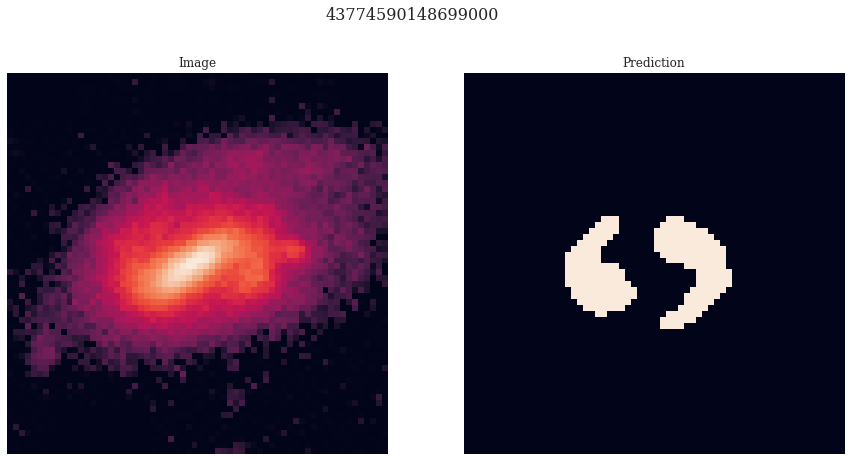

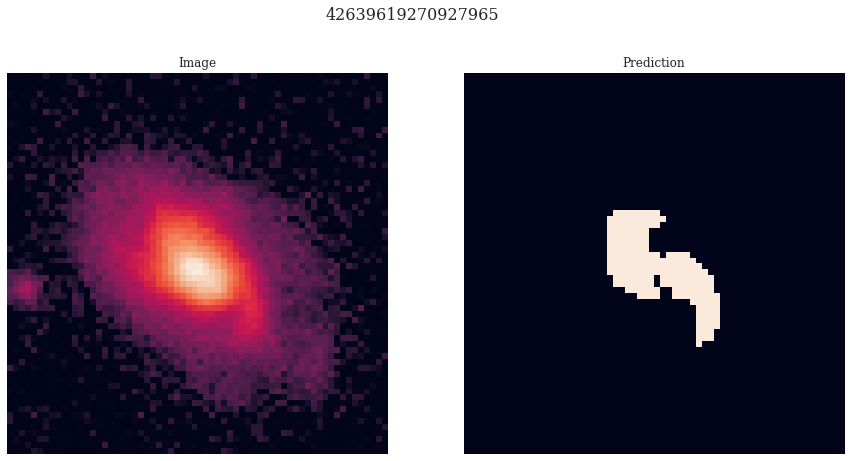

In [24]:
show_prediction_sample(images=images, preds=preds, n_sample=5)

### Catalogue Analysis


In [17]:
# Get Pixel Intensity Ratios and Estimated Flux Ratios
pixel_ratios = get_pixel_intensity_ratios(masks=preds, images=images)
flux_ratios = get_flux_ratios(masks=preds, images=images)

In [18]:
# Read catalog
catalog_df = pd.read_csv(CATALOG_PATH, index_col="object_id")

# Add flux_ratios as new column to catalog
flux_df = pd.DataFrame.from_dict(
    flux_ratios, orient="index", columns=["flux_ratio"]
)
flux_df.index = flux_df.index.astype("uint64")

# Note that 90 images are missing that appear in the catalog
catalog_df = catalog_df.merge(
    flux_df, left_index=True, right_index=True, how="left"
)

# Save updated catalog as .csv
catalog_df.to_csv(UPDATED_CATALOG_PATH)

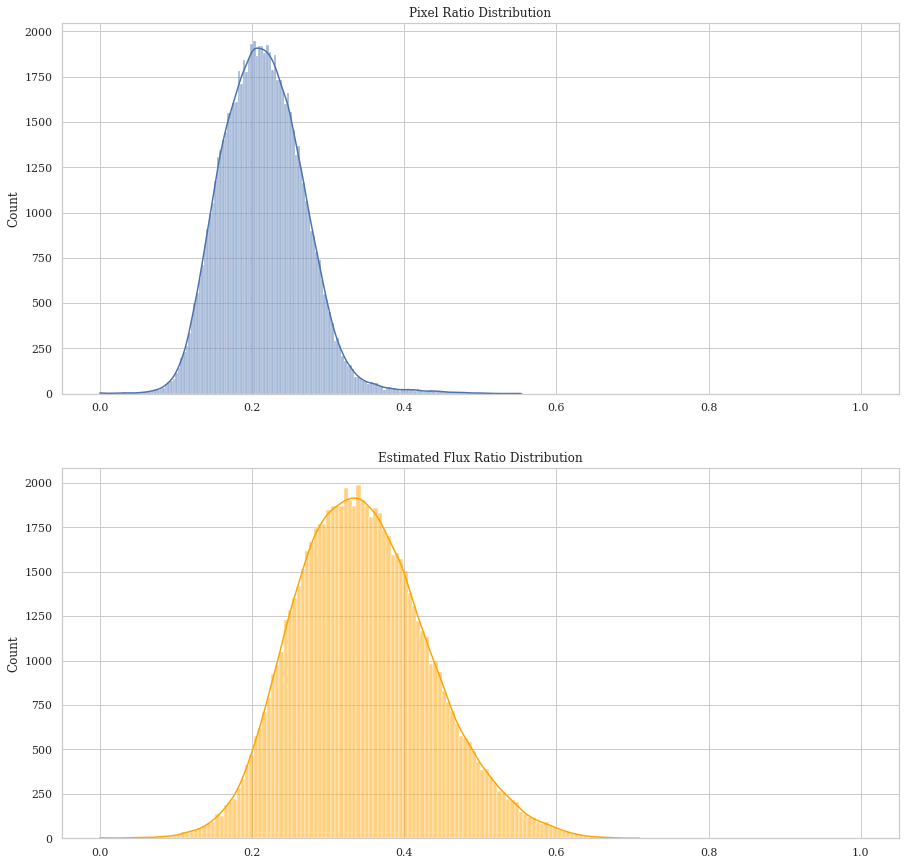

In [19]:
"""Plot distributions of flux and pixel intensity ratios on histogram over 0->1"""

fig, ax = plt.subplots(2, 1, figsize=(15, 15))

sns.histplot(x=pixel_ratios.values(), ax=ax[0], kde=True, binrange=(0, 1)).set(
    title="Pixel Ratio Distribution"
)
sns.histplot(
    x=flux_ratios.values(), ax=ax[1], color="orange", kde=True, binrange=(0, 1)
).set(title="Estimated Flux Ratio Distribution")

ax[0].legend([], [], frameon=False)
ax[1].legend([], [], frameon=False)

plt.show()

In [20]:
"""Helkper method to plot correlation between two columns of a dataframe"""


def plot_correlation(df, x, y, xlabel, ylabel, binmin=0, binmax=1, num_bins=10):
    # Plot mean flux ratio at each bin of z of size 0.1
    fig, ax = plt.subplots(2, 1, figsize=(15, 15))
    with warnings.catch_warnings():
        # Catch block to suppress warnings from correlation calculations
        warnings.simplefilter("ignore")
        pearson = df.corr()[x][y]
        kendall = df.corr(method="kendall")[x][y]
        spearman = df.corr(method="spearman")[x][y]

        fig.suptitle(
            f"Correlation Coefficients: Pearson: {pearson:.3f}, Kendall: {kendall:.3f}, Spearman: {spearman:.3f}",
            y=0.08,
        )

    bin_width = (binmax - binmin) / num_bins
    ticks = [
        f"[{binmin:.1f}, {binmin+bin_width:.1f})"
        for binmin in np.arange(binmin, binmax, bin_width)
    ]

    z_filtered = df.groupby(
        pd.cut(df[x], np.arange(binmin, binmax + bin_width, bin_width))
    )[y].mean()

    sns.barplot(
        y=z_filtered, x=z_filtered.index, color="blue", alpha=0.7, ax=ax[0]
    ).set(
        title=f"Mean {ylabel} at Each Bin of z",
        xlabel=xlabel,
        ylabel=f"Mean {ylabel}",
        xticklabels=ticks,
    )

    # Plot scatter plot of flux ratio vs redshift
    sns.scatterplot(
        data=df,
        y=y,
        x=x,
        color="orange",
        alpha=0.5,
        ax=ax[1],
    ).set(
        title=f"{xlabel} vs {ylabel}",
        xlabel=xlabel,
        ylabel=ylabel,
    )

    plt.show()

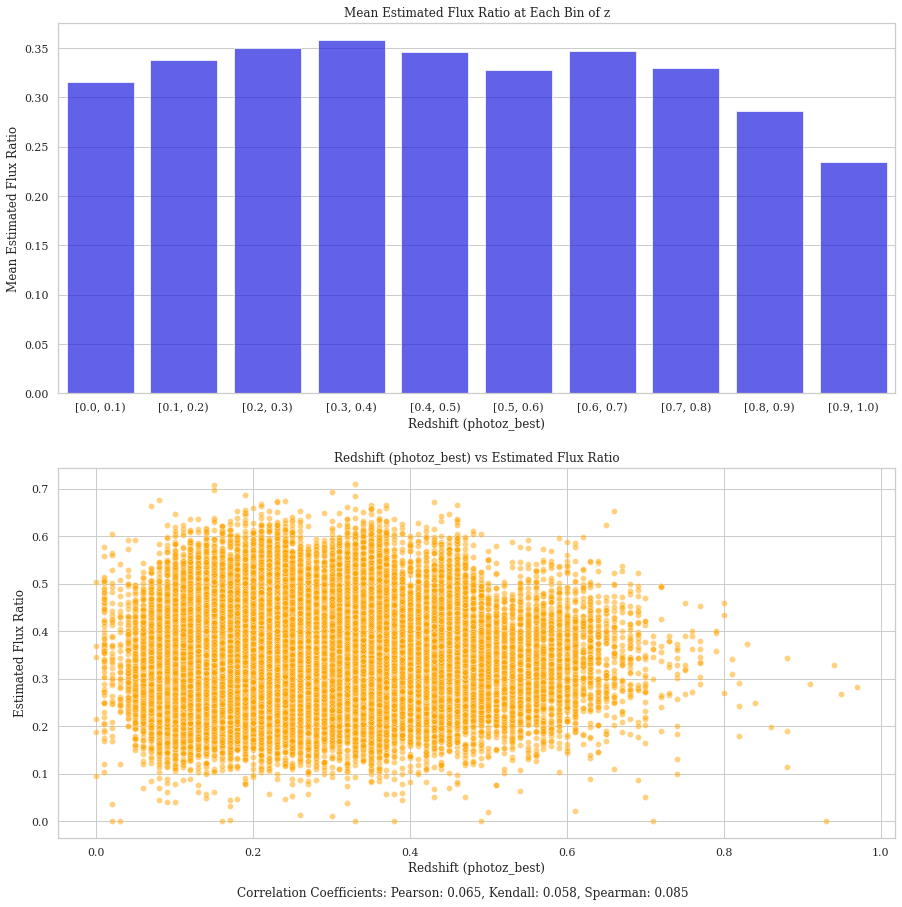

In [21]:
"""Plot instance and mean flux_ratio vs Redshift (photoz_best)"""

# Filter out high risk redshifts (<0.5 confidence) & redshift > 1
z_filtered_df = catalog_df[catalog_df["photoz_risk_best"] <= 0.5]
z_filtered_df = z_filtered_df[z_filtered_df["photoz_best"] <= 1]
z_filtered_df = z_filtered_df[z_filtered_df["photoz_best"] >= 0]

# Plot mean flux ratio at each bin of z of size 0.1
plot_correlation(
    z_filtered_df,
    "photoz_best",
    "flux_ratio",
    "Redshift (photoz_best)",
    "Estimated Flux Ratio",
)

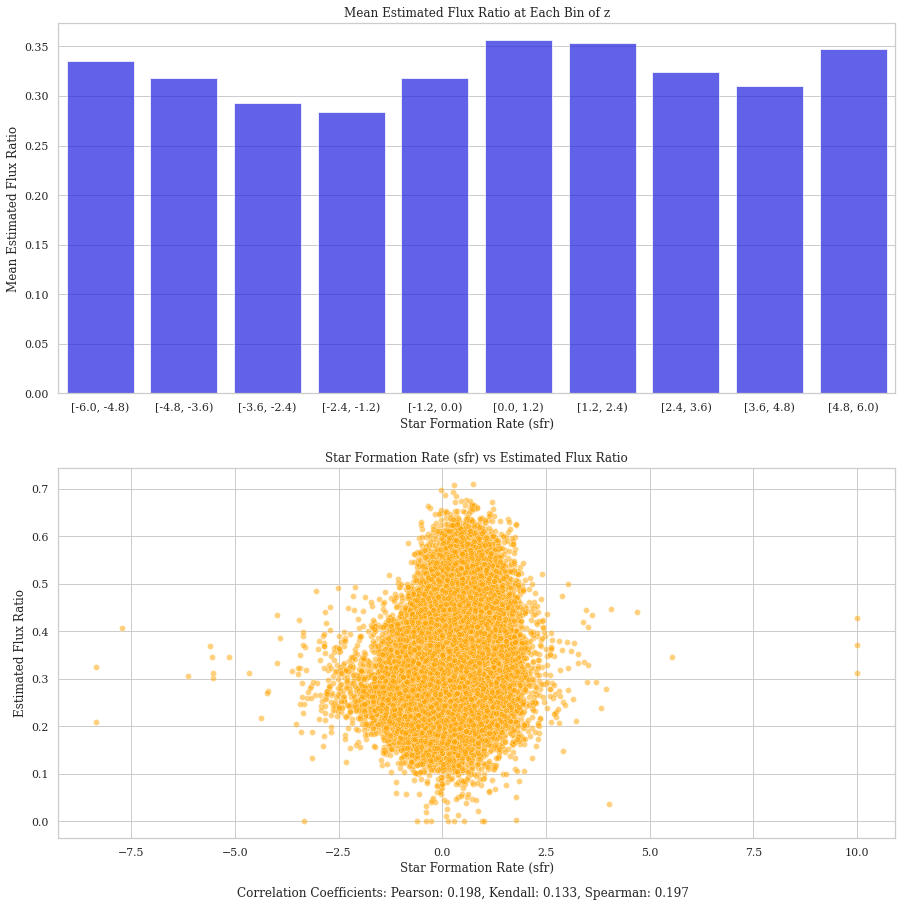

In [22]:
"""Plot instance and mean flux_ratio vs Star Formation Rate (sfr)"""

# Filter out oultier sfrs
sfr_filtered_df = catalog_df[catalog_df["sfr"] <= 10]
sfr_filtered_df = sfr_filtered_df[sfr_filtered_df["sfr"] >= -10]

# Plot correlation
plot_correlation(
    sfr_filtered_df,
    "sfr",
    "flux_ratio",
    "Star Formation Rate (sfr)",
    "Estimated Flux Ratio",
    binmin=-6,
    binmax=6,
)

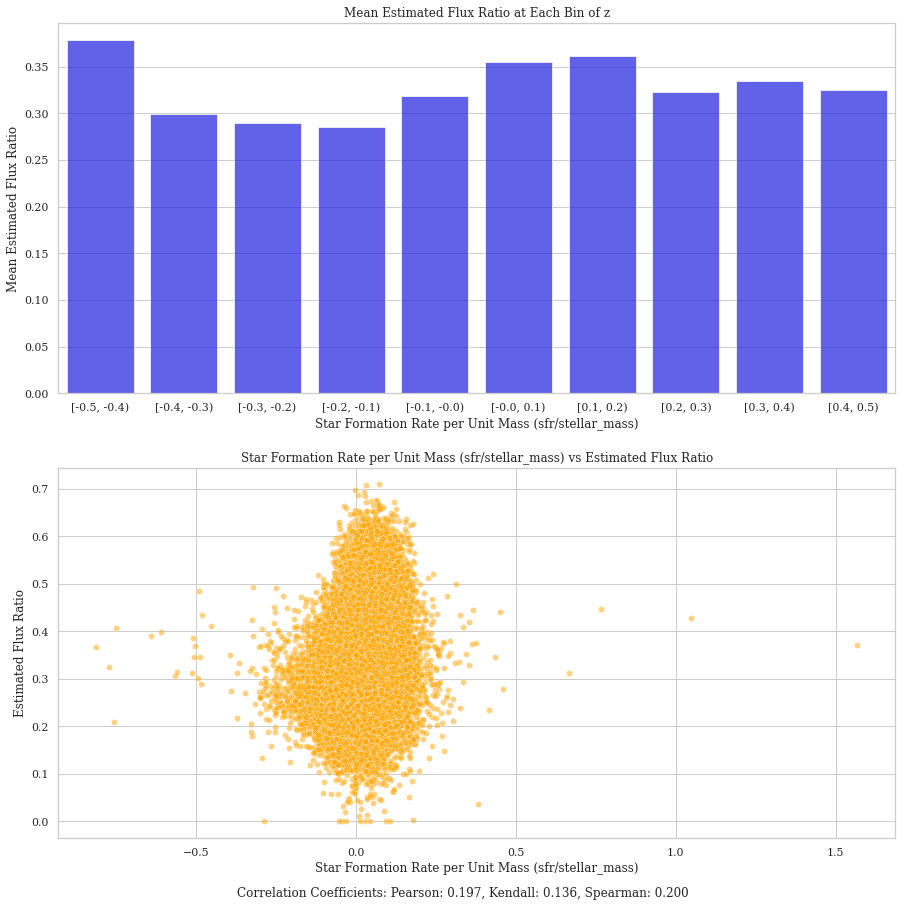

In [23]:
"""Plot instance and mean flux_ratio vs Star Formation Rate per unit mass (sfr/stellar_mass)"""

# Filter out oultier sfrs
sfr_m_filtered_df = sfr_filtered_df
sfr_m_filtered_df["sfr_per_mass"] = (
    sfr_m_filtered_df["sfr"] / sfr_m_filtered_df["stellar_mass"]
)

# Plot correlation
plot_correlation(
    sfr_m_filtered_df,
    "sfr_per_mass",
    "flux_ratio",
    "Star Formation Rate per Unit Mass (sfr/stellar_mass)",
    "Estimated Flux Ratio",
    binmin=-0.5,
    binmax=0.5,
)